# Final Project STATS 507 

In this project, I will investigate comments on politicians Facebook posts to see if there is a clear distinction between the rhetoric in the comments of the posts of Democrats versus Republicans.This will be achieved through a Multi-Layer Perceptron using tools as text embeddings from Word2Vec. Through cross-validation I will find which gives the optimal parameters for the network and apply that to a test data set to see if this network is useful at predicting political party. In addition, I'll try different pooling methods and word vector lengths at the end of the file. 

### Step 1: Reset/Download Preloaded Packages to Accommodate Data Pipeline

These are the specific versions of the packages I installed to run this pipeline. Errors may show up if you have a different version of one of these packages, but I commented these out just in case you already have them installed/don't want to change the version in your computer. 

In [390]:
#pip install --upgrade datasets

In [391]:
#pip install pyarrow==13.0.0

In [392]:
#pip install --upgrade pyarrow datasets

In [393]:
#pip install gensim

In [394]:
#pip install scipy==1.12

In [395]:
#pip install nltk

In [396]:
#pip install tensorflow

### Step 2: Import Required Packages / Dataset  

In [398]:
from datasets import load_dataset

ds = load_dataset("thien/political", "classifier")

In [399]:
import pandas as pd

In [400]:
from numpy import triu
import numpy as np

In [401]:
import tensorflow as tf

In [402]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [403]:
import seaborn as sns

In [404]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [405]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [406]:
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
 
warnings.filterwarnings(action='ignore')

In [407]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/carolinemoy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Step 3: Mutate Datasets for Word2Vec Compatibility

When downloaded from Hugging Face the datasets are already naturally split into training, evaluation, and testing groups. When downloading the datasets into pandas DataFrames maintaining this strucutre allowed for easy download and the splits were decided to be kept as so. However, in future study the labels could be permuted to see if similar results hold. 

In [410]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'raw_text', 'filename', 'text', 'split', 'label'],
        num_rows: 80000
    })
    eval: Dataset({
        features: ['id', 'raw_text', 'filename', 'text', 'split', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'raw_text', 'filename', 'text', 'split', 'label'],
        num_rows: 56000
    })
})

From this we can see the columns in each data frame, as well as the number of rows in each. 

In [412]:
tweets_train = pd.DataFrame(ds['train'])
tweets_eval = pd.DataFrame(ds['eval'])
tweets_test = pd.DataFrame(ds['test'])

Combining all into one dataframe for simplicity. 

In [414]:
tweets_all = pd.concat([tweets_train, tweets_eval, tweets_test])

Selecting relevant columns 

In [416]:
tweets_all = tweets_all[['text', 'split', 'label']]

In [417]:
tweets_all['text_filtered'] = tweets_all['text'].str.replace("[.,!?'-:]", '', regex = True)

Tokenizing each text column to make compatible for Word2Vec

In [419]:
tweets_all['tokens'] = tweets_all['text_filtered'].apply(lambda x: word_tokenize(x.lower()))

Counting the number of words in each comment and computing statistics. 

In [421]:
tweets_all['num_words'] = tweets_all['tokens'].apply(lambda x: len(x))

In [422]:
tweets_all['num_words'].describe()

count    140000.000000
mean         14.022929
std           9.093388
min           0.000000
25%           7.000000
50%          12.000000
75%          18.000000
max         108.000000
Name: num_words, dtype: float64

[Text(0.5, 0, 'Number of Words in Comment'),
 Text(0.5, 1.0, 'Length of Comments for All Data')]

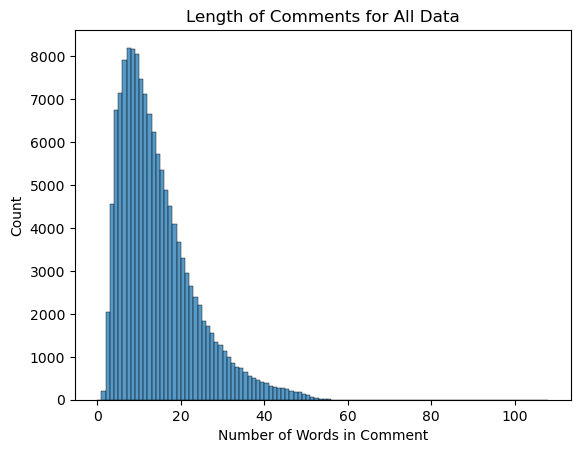

In [423]:
ax = sns.histplot(data = tweets_all, x = 'num_words', binwidth = 1)
ax.set(xlabel = "Number of Words in Comment", title = "Length of Comments for All Data")

Investigating if there's a difference in comment length based on political party. 

In [425]:
dem_tweet_stat = tweets_all[tweets_all['label'] == 'democratic']['num_words'].describe()
rep_tweet_stat = tweets_all[tweets_all['label'] == 'republican']['num_words'].describe()
print("Democrats", dem_tweet_stat); print("Republicans", rep_tweet_stat)

Democrats count    70000.000000
mean        13.886614
std          9.264905
min          0.000000
25%          7.000000
50%         12.000000
75%         18.000000
max        108.000000
Name: num_words, dtype: float64
Republicans count    70000.000000
mean        14.159243
std          8.916556
min          1.000000
25%          8.000000
50%         12.000000
75%         19.000000
max         90.000000
Name: num_words, dtype: float64


[Text(0.5, 0, 'Number of Words'),
 Text(0, 0.5, 'Number of Comments'),
 Text(0.5, 1.0, 'Comments on Democrats Post Length Distribution')]

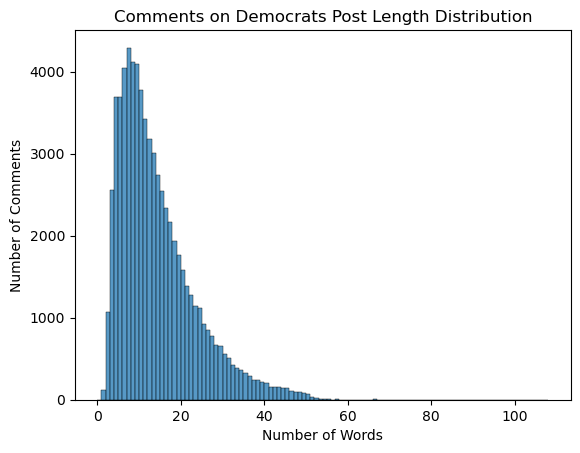

In [426]:
democrat_tweet_length = tweets_all[tweets_all['label'] == 'democratic']['num_words']
democrat_tweet_length_graph = sns.histplot(data = democrat_tweet_length, binwidth = 1)
democrat_tweet_length_graph.set(xlabel = "Number of Words", 
                 ylabel = "Number of Comments", 
                 title = "Comments on Democrats Post Length Distribution")

[Text(0.5, 0, 'Number of Words'),
 Text(0, 0.5, 'Number of Comments'),
 Text(0.5, 1.0, 'Comments on Republicans Post Length Distribution')]

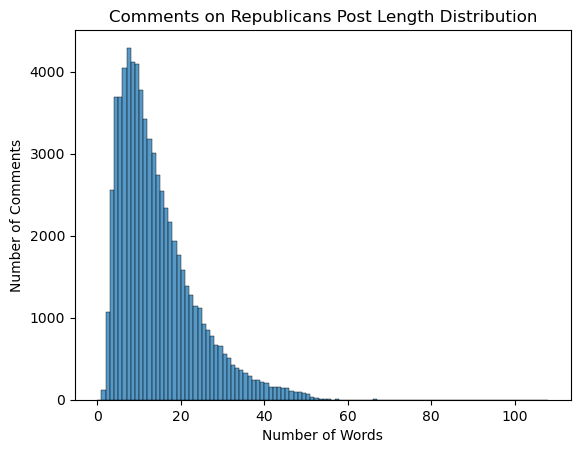

In [427]:
republican_tweet_length = tweets_all[tweets_all['label'] == 'republican']['num_words']
republican_tweet_length_graph = sns.histplot(data = democrat_tweet_length, binwidth = 1)
republican_tweet_length_graph.set(xlabel = "Number of Words", 
                 ylabel = "Number of Comments", 
                 title = "Comments on Republicans Post Length Distribution")

We can see that they are not signficantly different and have very similar statistics. 

Graph showing the number of comments per political party in each split of the data. 

[Text(0.5, 0, 'Data Split (from Hugging Face)'),
 Text(0, 0.5, 'Number of Comments'),
 Text(0.5, 1.0, "Data Split and Comments' Political Affiliation")]

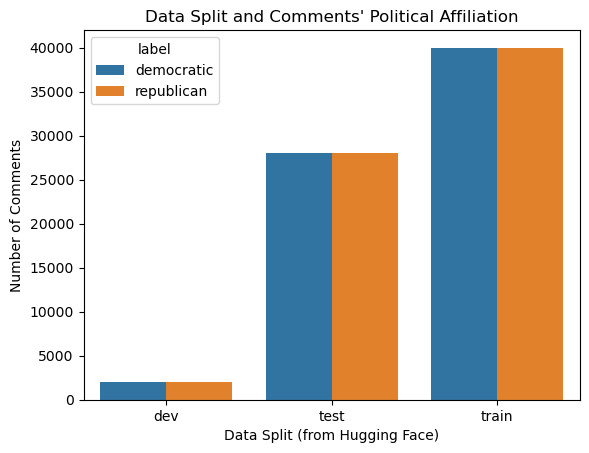

In [430]:
## displaying the number of rows in train, eval, and test -- show even split democrat republican 
split_label_df = tweets_all.groupby(['split', 'label']).size().reset_index(name='count')
counts_graph = sns.barplot(data = split_label_df, x = 'split', y = 'count', hue = 'label')
counts_graph.set(xlabel = "Data Split (from Hugging Face)", 
                 ylabel = "Number of Comments", 
                 title = "Data Split and Comments' Political Affiliation")

We can see that there's an even split of Democrat and Republican tweets in each data split. 

Finding top 10 buzzwords

In [433]:
tokens_list_list = tweets_all['tokens'].tolist()
flat_list = [
    x
    for xs in tokens_list_list
    for x in xs
]

First looking at words that are only over 3 characters

In [435]:
list1 = [x for x in flat_list if len(x) > 3]
common_words = ['the', 'and', 'with', 'are', 'for', 'that', 
                'you', 'your', 'have', 'our', 'this', 'what', 
                'from', 'about','like', 'they', 'will', 'just', 
               'would', 'has', 'who', 'his', 'was', 'should']
list_filtered = [x for x in list1 if x not in common_words]

In [436]:
words = pd.DataFrame(list_filtered)
words.rename(columns={0: 'word'}, inplace=True)

In [437]:
word_counts = pd.DataFrame(words.groupby('word').size().reset_index(name='count'))

In [438]:
refined_words = word_counts.sort_values('count', ascending = False).head(10)
refined_words 

,word,count
30591,senator,8421
25163,people,8083
23488,obama,6958
34182,thank,6380
36862,vote,6135
26491,president,4807
35290,trump,4756
22686,need,4706
25763,please,4640
22061,more,4546


None of the words are large partisan issues, instead it mentions past presidents, or they are referencing other senators. Many of the words also seem to be encouraging people to vote or possibly donate to their campaigns.

Looking at words over 2 characters

In [441]:
list_basic = [x for x in flat_list if len(x) > 2]
words_basic = pd.DataFrame(list_basic)
words_basic.rename(columns={0: 'word'}, inplace=True)
word_counts_basic = pd.DataFrame(words_basic.groupby('word').size().reset_index(name='count'))
basic_words = word_counts_basic.sort_values('count', ascending = False).head(10)
basic_words

,word,count
35631,the,85728
1394,and,54463
40158,you,49323
13740,for,33333
35612,that,20523
1871,are,16728
40188,your,14825
24274,not,14689
35838,this,14235
16041,have,13758


This is an expected result because the common words aren't filtered, instead this just looks at the most common words that are over 2 characters.

Republican word pattern investigations. 

In [444]:
tokens_list_list_rep = tweets_all[tweets_all['label'] == 'republican']['tokens'].tolist()
flat_list_rep = [
    x
    for xs in tokens_list_list_rep
    for x in xs
]
list1_rep = [x for x in flat_list_rep if len(x) > 3]
list_filtered_rep = [x for x in list1_rep if x not in common_words]

In [445]:
words_rep = pd.DataFrame(list_filtered_rep)
words_rep.rename(columns={0: 'word'}, inplace=True)
word_rep_counts = pd.DataFrame(words_rep.groupby('word').size().reset_index(name='count'))
refined_words_rep = word_rep_counts.sort_values('count', ascending = False).head(10)
refined_words_rep

,word,count
14047,obama,6423
15107,people,4143
22330,vote,3277
15923,president,3011
8925,government,2619
6276,dont,2609
13630,need,2546
4206,congress,2522
4639,country,2520
14978,paul,2514


Democrat

In [447]:
tokens_list_list_dem = tweets_all[tweets_all['label'] == 'democratic']['tokens'].tolist()
flat_list_dem = [
    x
    for xs in tokens_list_list_dem
    for x in xs
]
list1_dem = [x for x in flat_list_dem if len(x) > 3]
list_filtered_dem = [x for x in list1_dem if x not in common_words]

In [448]:
words_dem = pd.DataFrame(list_filtered_dem)
words_dem.rename(columns={0: 'word'}, inplace=True)
word_dem_counts = pd.DataFrame(words_dem.groupby('word').size().reset_index(name='count'))
refined_words_dem = word_dem_counts.sort_values('count', ascending = False).head(10)
refined_words_dem

,word,count
22748,senator,6336
25468,thank,6213
27623,warren,4159
26252,trump,4079
18669,people,3940
2411,bernie,3515
8220,elizabeth,3209
19128,please,2920
27446,vote,2858
11839,hillary,2402


The main difference is that Democrats mention their own party members more, and Republicans have more general words about government. 

### Step 4: Applying Word2Vec 

Creating word embedding vectors of different lengths to test accuracy later in the pipeline. The main pipeline was refined with word embeddings of length 100. 

In [452]:
word_vecs100 = Word2Vec(tweets_all['tokens'], vector_size=100, window=5, min_count=1, workers=4)
# vector size captures how long the vector is for each word 

Removing rows with a token length of 0, in this case it's only a singular row, and the comment is "2020!" I previously removed punctuation and Word2Vec doesn't recognize the 2020. If this row is kept in the following rows will error. 

In [454]:
tweets_all = tweets_all[tweets_all['tokens'].apply(lambda x: len(x) != 0)]

### Republican as 0, Democrat as 1

In [456]:
tweets_all['label_coded'] = tweets_all['label'].map({'republican': 0, 'democratic' : 1})

### Step 5: Mapping Word Embeddings to Tweets and Finding Common Vector

In [458]:
tweets_all['avg_word_vec'] = tweets_all['tokens'].apply(lambda x: np.mean(word_vecs100.wv[x], axis=0))

In [459]:
tweets_all['sum_word_vec'] = tweets_all['tokens'].apply(lambda x: np.sum(word_vecs100.wv[x], axis=0))

In [460]:
tweets_all['max_word_vec'] = tweets_all['tokens'].apply(lambda x: np.max(word_vecs100.wv[x], axis=0))

Converting datasets to tensors for Averages 

In [462]:
# Standardizing
scaler = StandardScaler()
avg_word_vecs = tweets_all['avg_word_vec'].tolist()
standardized_vecs = scaler.fit_transform(avg_word_vecs)

Resetting the index because we removed one row above; important to note we don't need to use the reset index dataset for evaluation and test because each training split has their own indices, example there are three rows with an indices of 1 (the first row of each data split). 

In [464]:
filtered_tweets_all = tweets_all.reset_index(drop=True)

In [465]:
X_train = torch.tensor(standardized_vecs[filtered_tweets_all['split'] == 'train'], dtype=torch.float32)
y_train = torch.tensor(filtered_tweets_all[filtered_tweets_all['split'] == 'train']['label_coded'])
training_dataset = TensorDataset(X_train, y_train)

In [466]:
X_eval = torch.tensor(standardized_vecs[tweets_all['split'] == 'dev'], dtype=torch.float32)
y_eval = torch.tensor(tweets_all[tweets_all['split'] == 'dev']['label_coded'])
eval_dataset = TensorDataset(X_eval, y_eval)

In [467]:
X_test = torch.tensor(standardized_vecs[tweets_all['split'] == 'test'], dtype=torch.float32)
y_test = torch.tensor(tweets_all[tweets_all['split'] == 'test']['label_coded'])
test_dataset = TensorDataset(X_test, y_test)

### Step 7: Defining the Model 

In [469]:
class MultiLayerPerceptron(nn.Module): 
    def __init__(self, num_features, hidden_size1, hidden_size2, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        # 1st hidden layer 
        self.linear1 = nn.Linear(num_features, hidden_size1)
        # 2nd hidden layer
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        # output layer 
        self.linear_output = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x): 
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear_output(x) #logits
        #probs = F.sigmoid(logits, dim=1)
        return x

### Step 8: Cross Validating to Find Best Hyperparameters

In [471]:
'''
def selecting_hyperparameters(num_iterations = 10):
    best_value_loss = float('inf')
    best_hyperparameters = None 

    for iteration in range(num_iterations):
        batch_size = int(np.random.choice([32, 64, 128]))
        hyperparameters = {
            'learning_rate': np.random.choice([1e-2, 1e-3, 1e-4]), 
            'hidden_size1' : np.random.choice([32, 64, 128]), 
            'hidden_size2' : np.random.choice([16, 32, 64]), 
            'batch_size' : batch_size}

        model = MultiLayerPerceptron(num_features, hidden_size1, hidden_size2, num_classes)
        dataloader = DataLoader(training_dataset, batch_size = hyperparameters['batch_size'], shuffle = True)

        loss_func = nn.BCEWithLogitsLoss() #BCELoss() 
        optimizer = torch.optim.Adam(model.parameters())

        model.train()

        for epoch in range(20): 
            total_loss = 0

            for batch_X, batch_y in dataloader:
        #logits, outputs = model(batch_X)
        #batch_X = batch_X.to(device)
        #batch_y = batch_y.float().to(device)
                optimizer.zero_grad()

                outputs = model(batch_X)

                outputs = outputs.squeeze()

                batch_y = batch_y.float()

                loss = loss_func(outputs, batch_y)

            
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        model.eval()
        eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in dataloader:
            
                outputs = model(batch_X)

                outputs = outputs.squeeze()

                batch_y = batch_y.float()

                loss = loss_func(outputs, batch_y)

                val_loss += loss.item()

        if best_value_loss > val_loss:
            best_value_loss = val_loss
            best_hyperparameters = hyperparameters
            best_model = model 

    print("Optimal Hyperparameters", best_hyperparameters)
    print("Best Validation Loss", best_value_loss)

    return best_model, best_hyperparameters
'''

'\ndef selecting_hyperparameters(num_iterations = 10):\n    best_value_loss = float(\'inf\')\n    best_hyperparameters = None \n\n    for iteration in range(num_iterations):\n        batch_size = int(np.random.choice([32, 64, 128]))\n        hyperparameters = {\n            \'learning_rate\': np.random.choice([1e-2, 1e-3, 1e-4]), \n            \'hidden_size1\' : np.random.choice([32, 64, 128]), \n            \'hidden_size2\' : np.random.choice([16, 32, 64]), \n            \'batch_size\' : batch_size}\n\n        model = MultiLayerPerceptron(num_features, hidden_size1, hidden_size2, num_classes)\n        dataloader = DataLoader(training_dataset, batch_size = hyperparameters[\'batch_size\'], shuffle = True)\n\n        loss_func = nn.BCEWithLogitsLoss() #BCELoss() \n        optimizer = torch.optim.Adam(model.parameters())\n\n        model.train()\n\n        for epoch in range(20): \n            total_loss = 0\n\n            for batch_X, batch_y in dataloader:\n        #logits, outputs = mo

In [472]:
#best_model, best_hyperparams = selecting_hyperparameters()

What the above cell will look like when ran (however commented these out because it takes about an hour and a half to run). Used these hyperparameters for my analysis. 

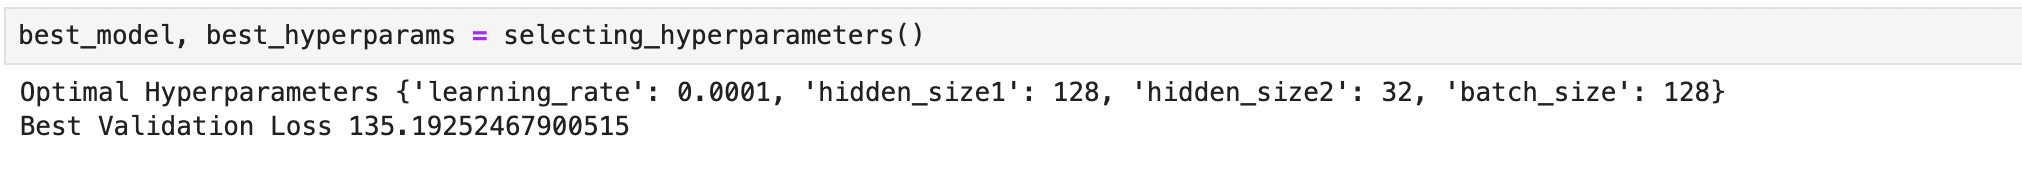

### Step 9: Training the Model Based on Best Hyperparameters

In [476]:
num_features = 100
# hidden is how many perceptrons 
hidden_size1 = 128
hidden_size2 = 32
num_classes = 1  # Binary classification

learning_rate = 0.0001
epochs = 100

batch_size = 128

In [477]:
model = MultiLayerPerceptron(num_features, hidden_size1, hidden_size2, num_classes)

In [478]:
loss_func = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters()) 

In [479]:
dataloader = DataLoader(training_dataset, batch_size = batch_size, shuffle = True)

In [480]:
loss_epochs = pd.DataFrame({'epoch': [], 'loss': []})
for epoch in range(epochs): 
    model.train()
    total_loss = 0
    num_batches = 0

    for batch_X, batch_y in dataloader:
        #logits, outputs = model(batch_X)
        #batch_X = batch_X.to(device)
        #batch_y = batch_y.float().to(device)

        outputs = model(batch_X)

        outputs = outputs.squeeze()

        batch_y = batch_y.float()

        loss = loss_func(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1


    epoch_avg_loss = total_loss / num_batches
    new_row = {'epoch': epoch, 'loss': loss.item()}
    loss_epochs = pd.concat([loss_epochs, pd.DataFrame([new_row])], ignore_index=True)
    if (epoch + 1) % 10 == 0:
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.2365
Epoch [20/100], Loss: 0.1480
Epoch [30/100], Loss: 0.1433
Epoch [40/100], Loss: 0.0795
Epoch [50/100], Loss: 0.0868
Epoch [60/100], Loss: 0.1079
Epoch [70/100], Loss: 0.0811
Epoch [80/100], Loss: 0.1188
Epoch [90/100], Loss: 0.0805
Epoch [100/100], Loss: 0.1027


In [481]:
for param in model.parameters():
    if param.grad is not None:
        print(param.grad.abs().mean())

tensor(0.0088)
tensor(0.0115)
tensor(0.0081)
tensor(0.0114)
tensor(0.0286)
tensor(0.0285)


[Text(0.5, 0, 'Number of Epochs'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Loss Over 100 Epochs')]

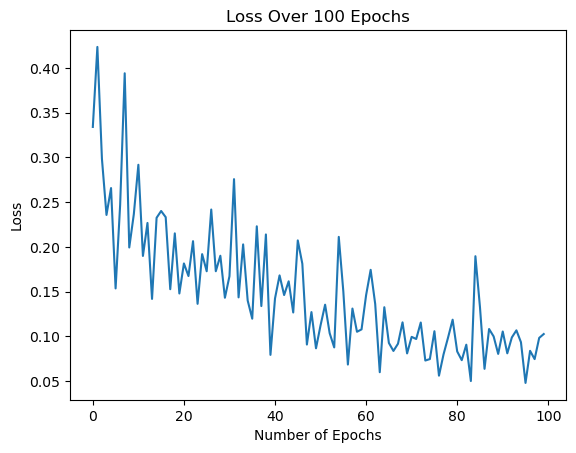

In [482]:
ax2 = sns.lineplot(data = loss_epochs, x = 'epoch', y = 'loss')
ax2.set(xlabel = "Number of Epochs", ylabel = "Loss", title = "Loss Over 100 Epochs")

### Step 10: Testing Model Based on Trained Model

In [484]:
model.eval()
outputs = model(X_test)
outputs.squeeze()
predicted_probs = torch.sigmoid(outputs)
predicted_labels = (predicted_probs > 0.5).float()
predicted_ys = predicted_labels.squeeze().long()

In [485]:
accuracy = sum(predicted_ys == y_test) / len(y_test)
accuracy = accuracy.numpy()
accuracy

array(0.86314285, dtype=float32)

In [486]:
precision_score(y_test, predicted_ys)

0.8672614317705699

In [487]:
recall_score(y_test, predicted_ys)

0.8575357142857143

### Step 11: Visualization 

Finding true positive, true negative, false positive, false negative... 'republican': 0, 'democratic' : 1

In [490]:
conf_mat = confusion_matrix(y_test, predicted_ys)

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Confusion Matrix')]

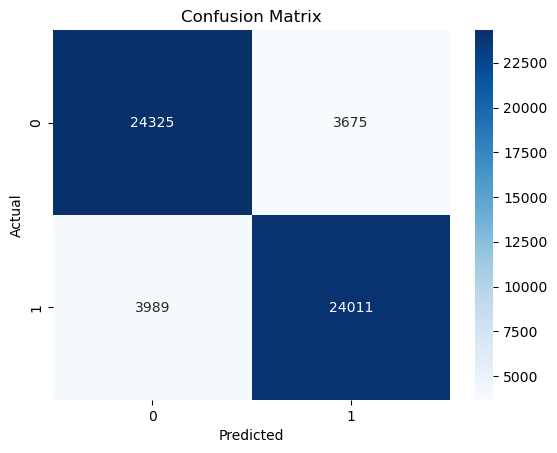

In [491]:
conf_graph = sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap = 'Blues')
conf_graph.set(xlabel = "Predicted", 
               ylabel = "Actual", 
               title = "Confusion Matrix")

In [492]:
false_tens = (y_test != predicted_ys)
indices_false = false_tens.nonzero()

In [493]:
indices_false_list = indices_false.numpy().flatten().tolist()

In [494]:
test_index = tweets_all[tweets_all['split'] == 'test'].reset_index()
incorrect_classified_tweets = test_index[test_index['index'].isin(indices_false_list)]

In [495]:
incorrect_classified_tweets['num_words'].mean()

15.617823590814195

Because split, predicted truth versus not at almost at the same ratio. 

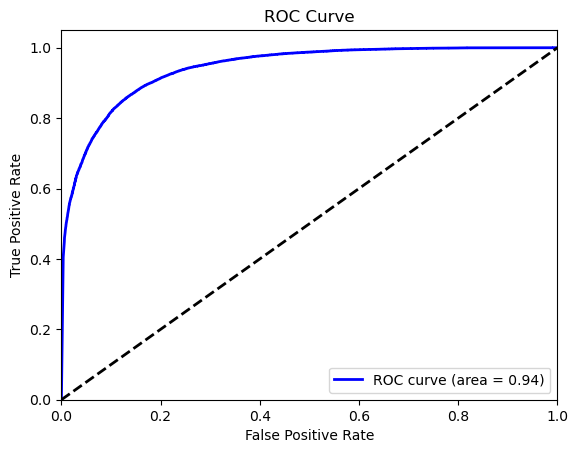

In [497]:
fpr, tpr, thresholds = roc_curve(y_test, predicted_probs.detach().numpy())

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Step 12: Comparing to More Basic Models

In [499]:
logr = linear_model.LogisticRegression()
logr.fit(X_train, y_train)

LogisticRegression()

In [500]:
log_reg_preds = logr.predict(X_test)
accuracyL = sum(log_reg_preds == y_test) / len(y_test)
accuracyL = accuracyL.numpy()
accuracyL

array(0.805, dtype=float32)

performs slightly worse than my model but only by like 5-6% 

### Extra Step: Show how you apply this to word vectors of different length and of different pooling methods 

Note: This code can be condensed with a for loop for future investigation (however that is not implemented here because I tried with only a few different methods). I simply tested pooling using sums and maximums with vector lengths of 100, and then tried different vector lengths with mean pooling. 

First with different pooling methods 

Vector Sums (length 100) 

In [506]:
sum_word_vecs = tweets_all['sum_word_vec'].tolist()
standardized_vecsS = scaler.fit_transform(sum_word_vecs)
X_trainS = torch.tensor(standardized_vecsS[filtered_tweets_all['split'] == 'train'], dtype = torch.float32)
y_trainS = torch.tensor(filtered_tweets_all[filtered_tweets_all['split'] == 'train']['label_coded'])
training_datasetS = TensorDataset(X_trainS, y_trainS)
X_testS = torch.tensor(standardized_vecsS[tweets_all['split'] == 'test'], dtype=torch.float32)
y_testS = torch.tensor(tweets_all[tweets_all['split'] == 'test']['label_coded'])
test_datasetS = TensorDataset(X_testS, y_testS)

In [507]:
modelS = MultiLayerPerceptron(num_features, hidden_size1, hidden_size2, num_classes)
loss_funcS = nn.BCEWithLogitsLoss() 
optimizerS = torch.optim.Adam(modelS.parameters()) 
dataloaderS = DataLoader(training_datasetS, batch_size = batch_size, shuffle = True)

In [508]:
#loss_epochs = pd.DataFrame({'epoch': [], 'loss': []})
for epoch in range(epochs): 
    modelS.train()
    total_loss = 0
    num_batches = 0

    for batch_X, batch_y in dataloaderS:
        #logits, outputs = model(batch_X)
        #batch_X = batch_X.to(device)
        #batch_y = batch_y.float().to(device)

        outputsS = modelS(batch_X)

        outputsS = outputsS.squeeze()

        batch_y = batch_y.float()

        loss = loss_funcS(outputsS, batch_y)

        optimizerS.zero_grad()
        loss.backward()
        optimizerS.step()

        total_loss += loss.item()
        num_batches += 1

In [509]:
modelS.eval()
outputsS = modelS(X_testS)
outputsS.squeeze()
predicted_probsS = torch.sigmoid(outputsS)
predicted_labelsS = (predicted_probsS > 0.5).float()
predicted_ysS = predicted_labelsS.squeeze().long()

accuracyS = sum(predicted_ysS == y_testS) / len(y_testS)
accuracyS = accuracyS.numpy()
accuracyS

array(0.85873216, dtype=float32)

Very similar performance to mean pooling! Mean pooling had an accuracy of 0.8619.

In [511]:
logrS = linear_model.LogisticRegression()
logrS.fit(X_trainS, y_trainS)
log_reg_predsS = logrS.predict(X_testS)
accuracyLS = sum(log_reg_predsS == y_testS) / len(y_testS)

accuracyLS = accuracyLS.numpy()
accuracyLS

array(0.80575, dtype=float32)

Again very similar to mean pooling where the accuracy was 0.8042.

Vector Maxes (length 100)

In [514]:
max_word_vecs = tweets_all['max_word_vec'].tolist()
standardized_vecsM = scaler.fit_transform(max_word_vecs)
X_trainM = torch.tensor(standardized_vecsM[filtered_tweets_all['split'] == 'train'], dtype = torch.float32)
y_trainM = torch.tensor(filtered_tweets_all[filtered_tweets_all['split'] == 'train']['label_coded'])
training_datasetM = TensorDataset(X_trainM, y_trainM)
X_testM = torch.tensor(standardized_vecsM[tweets_all['split'] == 'test'], dtype=torch.float32)
y_testM = torch.tensor(tweets_all[tweets_all['split'] == 'test']['label_coded'])
test_datasetM = TensorDataset(X_testM, y_testM)

In [515]:
modelM = MultiLayerPerceptron(num_features, hidden_size1, hidden_size2, num_classes)
loss_funcM = nn.BCEWithLogitsLoss() 
optimizerM = torch.optim.Adam(modelM.parameters()) 
dataloaderM = DataLoader(training_datasetM, batch_size = batch_size, shuffle = True)

In [516]:
for epoch in range(epochs): 
    modelM.train()
    total_loss = 0
    num_batches = 0

    for batch_X, batch_y in dataloaderM:

        outputsM = modelM(batch_X)

        outputsM = outputsM.squeeze()

        batch_y = batch_y.float()

        loss = loss_funcM(outputsM, batch_y)

        optimizerM.zero_grad()
        loss.backward()
        optimizerM.step()

        total_loss += loss.item()
        num_batches += 1

In [517]:
modelM.eval()
outputsM = modelM(X_testM)
outputsM.squeeze()
predicted_probsM = torch.sigmoid(outputsM)
predicted_labelsM = (predicted_probsM > 0.5).float()
predicted_ysM = predicted_labelsM.squeeze().long()

accuracyM = sum(predicted_ysM == y_testM) / len(y_testM)
accuracyM = accuracyM.numpy()
accuracyM

array(0.76689285, dtype=float32)

In [518]:
logrM = linear_model.LogisticRegression()
logrM.fit(X_trainM, y_trainM)
log_reg_predsM = logrM.predict(X_testM)
accuracyLM = sum(log_reg_predsM == y_testM) / len(y_testM)
accuracyLM = accuracyLM.numpy()
accuracyLM

array(0.73310715, dtype=float32)

Logistic Regression and the more sophisicated MLP performed worse with max pooling than mean or sum pooling. One word vector may be dominating the maximum vector. 

Creating word vectors of different lengths

In [521]:
word_vecs50 = Word2Vec(tweets_all['tokens'], vector_size=50, window=5, min_count=1, workers=4)
word_vecs200 = Word2Vec(tweets_all['tokens'], vector_size=200, window=5, min_count=1, workers=4)

In [522]:
tweets_all['avg_word_vec50'] = tweets_all['tokens'].apply(lambda x: np.mean(word_vecs50.wv[x], axis = 0))
tweets_all['avg_word_vec200'] = tweets_all['tokens'].apply(lambda x: np.mean(word_vecs200.wv[x], axis = 0))

Mean Pooling (length 50)

In [524]:
word_vecs50 = tweets_all['avg_word_vec50'].tolist()
standardized_vecs50 = scaler.fit_transform(word_vecs50)
X_train50 = torch.tensor(standardized_vecs50[filtered_tweets_all['split'] == 'train'], dtype = torch.float32)
y_train50 = torch.tensor(filtered_tweets_all[filtered_tweets_all['split'] == 'train']['label_coded'])
training_dataset50 = TensorDataset(X_train50, y_train50)
X_test50 = torch.tensor(standardized_vecs50[tweets_all['split'] == 'test'], dtype=torch.float32)
y_test50 = torch.tensor(tweets_all[tweets_all['split'] == 'test']['label_coded'])
test_dataset50 = TensorDataset(X_test50, y_test50)

In [525]:
num_features50 = 50
model50 = MultiLayerPerceptron(num_features50, hidden_size1, hidden_size2, num_classes)
loss_func50 = nn.BCEWithLogitsLoss() 
optimizer50 = torch.optim.Adam(model50.parameters()) 
dataloader50 = DataLoader(training_dataset50, batch_size = batch_size, shuffle = True)

In [526]:
for epoch in range(epochs): 
    model50.train()
    total_loss = 0
    num_batches = 0

    for batch_X, batch_y in dataloader50:

        outputs50 = model50(batch_X)

        outputs50 = outputs50.squeeze()

        batch_y = batch_y.float()

        loss = loss_func50(outputs50, batch_y)

        optimizer50.zero_grad()
        loss.backward()
        optimizer50.step()

        total_loss += loss.item()
        num_batches += 1

In [527]:
model50.eval()
outputs50 = model50(X_test50)
outputs50.squeeze()
predicted_probs50 = torch.sigmoid(outputs50)
predicted_labels50 = (predicted_probs50 > 0.5).float()
predicted_ys50 = predicted_labels50.squeeze().long()

accuracy50 = sum(predicted_ys50 == y_test50) / len(y_test50)
accuracy50 = accuracy50.numpy()
accuracyL200

array(0.8497857, dtype=float32)

In [528]:
logr50 = linear_model.LogisticRegression()
logr50.fit(X_train50, y_train50)
log_reg_preds50 = logr50.predict(X_test50)
accuracyL50 = sum(log_reg_preds50 == y_test50) / len(y_test50)
accuracyL50 = accuracyL50.numpy()
accuracyL50

array(0.77839285, dtype=float32)

Understandably a little less accurate than the vector of length 100 because theres less information captured!

Mean Pooling (length 200)

In [531]:
word_vecs200 = tweets_all['avg_word_vec200'].tolist()
standardized_vecs200 = scaler.fit_transform(word_vecs200)
X_train200 = torch.tensor(standardized_vecs200[filtered_tweets_all['split'] == 'train'], dtype = torch.float32)
y_train200 = torch.tensor(filtered_tweets_all[filtered_tweets_all['split'] == 'train']['label_coded'])
training_dataset200 = TensorDataset(X_train200, y_train200)
X_test200 = torch.tensor(standardized_vecs200[tweets_all['split'] == 'test'], dtype=torch.float32)
y_test200 = torch.tensor(tweets_all[tweets_all['split'] == 'test']['label_coded'])
test_dataset200 = TensorDataset(X_test200, y_test200)

In [532]:
num_features200 = 200
model200 = MultiLayerPerceptron(num_features200, hidden_size1, hidden_size2, num_classes)
loss_func200 = nn.BCEWithLogitsLoss() 
optimizer200 = torch.optim.Adam(model200.parameters()) 
dataloader200 = DataLoader(training_dataset200, batch_size = batch_size, shuffle = True)

In [533]:
for epoch in range(epochs): 
    model200.train()
    total_loss = 0
    num_batches = 0

    for batch_X, batch_y in dataloader200:

        outputs200 = model200(batch_X)

        outputs200 = outputs200.squeeze()

        batch_y = batch_y.float()

        loss = loss_func200(outputs200, batch_y)

        optimizer200.zero_grad()
        loss.backward()
        optimizer200.step()

        total_loss += loss.item()
        num_batches += 1

In [534]:
model200.eval()
outputs200 = model200(X_test200)
outputs200.squeeze()
predicted_probs200 = torch.sigmoid(outputs200)
predicted_labels200 = (predicted_probs200 > 0.5).float()
predicted_ys200 = predicted_labels200.squeeze().long()

accuracy200 = sum(predicted_ys200 == y_test200) / len(y_test200)
accuracy200 = accuracy200.numpy()
accuracy200

array(0.8780714, dtype=float32)

In [535]:
logr200 = linear_model.LogisticRegression()
logr200.fit(X_train200, y_train200)
log_reg_preds200 = logr200.predict(X_test200)
accuracyL200 = sum(log_reg_preds200 == y_test200) / len(y_test200)
accuracyL200 = accuracyL200.numpy()
accuracyL200

array(0.84905356, dtype=float32)

Only performs slightly better than the vector of length 100 in the Multi-Layer Perceptron, but 4% better on the logistic regression. In future work, it would be interesting to see what is the optimal vector length level, the shortest possible vector that yields the most accuracy before plateauing (where the elbow of the graph is). 

In [537]:
accuracy_df = pd.DataFrame({'Vector Length' : [100, 100, 100, 50, 200], 
             'Pooling Method' : ['Mean', 'Sum', 'Max', 'Mean', 'Mean'], 
             'Accuracy MLP' : [accuracy, accuracyS, accuracyM, accuracy50, accuracy200], 
             'Accuracy LR': [accuracyL, accuracyLS, accuracyLM, accuracyL50, accuracyL200]})

In [538]:
accuracy_df

,Vector Length,Pooling Method,Accuracy MLP,Accuracy LR
0,100,Mean,0.86314285,0.805
1,100,Sum,0.85873216,0.80575
2,100,Max,0.76689285,0.73310715
3,50,Mean,0.84014285,0.77839285
4,200,Mean,0.8780714,0.84905356


The best performer is with a vector length of 200, mean pooling, and multi-layer perceptron model. The sum pooling method of similar vector length would probably perform similarly (since they did for the case of vector of length 100), yet it wasn't tested here.